# Consumer Segmentation

Using clustering to segment consumers based on their 

consumption patterns and demographics. 
(Understand behaviors of specific consumer groups).



Features used for clustering so far:

monthly energy consumption

monthly_expense

number_of_family_members

floor_area_of_the_household

usage_of_solar_panels

energy_source_used_to_cook

In [44]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Loading data

In [45]:
leco_all = pd.DataFrame()
root_folder = '/lirneasia/data/lacuna/processed/sm_april_2024_dump'
directory = os.path.join(root_folder)

if os.path.exists(directory):
    files = os.listdir(directory)

    for file_name in files:
        if file_name.endswith('.csv'):
            file_path = os.path.join(root_folder, file_name)
                
            leco_data = pd.read_csv(file_path, low_memory=False)

            leco_all = pd.concat([leco_all, leco_data], ignore_index=False)

else:
    print("path wrong") 

survey_data = pd.read_csv('/lirneasia/data/lacuna/raw/Survey_data/Survey_wave_1_may_29.csv', low_memory=False)

### Data Preprocessing

In [46]:
leco_all['datetime'] = pd.to_datetime(leco_all['date'] + ' ' + leco_all['time'])
leco_all = leco_all.drop(columns=['date', 'time'])
leco_all = leco_all.sort_values(by=['customerref', 'datetime'])

#leco_all['meter_reading'] = pd.to_numeric(data['meter_reading'], errors='coerce')

In [47]:
leco_all['consumption'] = leco_all.groupby('customerref')['importkwh(kwh)'].diff().fillna(0)
leco_all['export'] = leco_all.groupby('customerref')['exportkwh(kwh)'].diff().fillna(0)

leco_all = leco_all[leco_all['consumption'] >= 0]
leco_all = leco_all[leco_all['export'] >= 0]

#### Monthly consumption calculation

In [48]:
#Monthly consumption
monthly_consumption = leco_all.set_index('datetime').groupby('customerref')['consumption'].resample('m').sum().reset_index()

/tmp/ipykernel_122731/3945495038.py:2: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_consumption = leco_all.set_index('datetime').groupby('customerref')['consumption'].resample('m').sum().reset_index()


In [49]:
monthly_consumption.head(20)

,customerref,datetime,consumption
0,101261710,2023-10-31,10.7980
1,101261710,2023-11-30,100.1420
2,101261710,2023-12-31,87.3701
3,101261710,2024-01-31,46.4719
4,101490906,2023-10-31,0.0010
5,101490906,2023-11-30,90.9220
6,101490906,2023-12-31,46.0680
7,101490906,2024-01-31,99.3530
8,101502005,2023-10-31,9.3431
9,101502005,2023-11-30,100.4509


In [50]:
monthly_consumption = monthly_consumption[monthly_consumption['datetime'] == '2023-11-30']
monthly_consumption

,customerref,datetime,consumption
1,101261710,2023-11-30,100.1420
5,101490906,2023-11-30,90.9220
9,101502005,2023-11-30,100.4509
13,101837010,2023-11-30,57.2870
17,103091604,2023-11-30,29.0810
...,...,...,...
5220,708358409,2023-11-30,135.7240
5222,708446805,2023-11-30,317.1450
5225,708512409,2023-11-30,72.7050
5228,708773307,2023-11-30,0.0000


#### Merging with survey data

In [8]:
sm = leco_all.drop_duplicates(subset=['customerref'])
merged = pd.merge(sm, survey_data, left_on='customerref', right_on='ACCOUNT_NO', how='inner')

In [9]:
merged = pd.merge(merged, monthly_consumption, left_on='customerref', right_on='customerref', how='inner')
merged

,serial,customerref,timestamp,obis,importkwh(kwh),exportkwh(kwh),importkvarh(kvarh),exportkvarh(kvarh),phaseainstcurrent(a),phasebinstcurrent(a),...,Sawing_Machine_availability,Wood_Chipping_Machine_availability,Concrete_Mixture_Machine_availability,Hair_Cutting_Machine_availability,Generator_Battery_availability,Bouth_availability,Grill_availability,LA_Unique_ID,datetime_y,consumption_y
0,22732556,101261710,1.698520e+12,LP,139.232,0.0000,NaN,NaN,0.4121,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10101261710,2023-11-30,100.1420
1,21721253,200134110,1.698550e+12,LP,1574.864,3412.9090,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10200134110,2023-11-30,135.2330
2,20708313,200700907,1.698530e+12,LP,3508.694,15727.3080,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10200700907,2023-11-30,132.1351
3,20708610,201661801,1.698540e+12,LP,2774.710,7651.4091,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10201661801,2023-11-30,136.9181
4,21721146,201929002,1.698550e+12,LP,2591.833,0.0010,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10201929002,2023-11-30,141.3410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,22730366,707123802,1.698530e+12,LP,33.020,0.0010,NaN,NaN,0.2320,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10707123802,2023-11-30,29.9420
280,23706149,707182311,1.697080e+12,LP,0.000,0.0000,NaN,NaN,0.0270,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10707182311,2023-11-30,245.9330
281,22729794,707436301,1.698530e+12,LP,292.258,0.0000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10707436301,2023-11-30,144.8160
282,22711706,708512409,1.698540e+12,LP,373.652,0.0000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10708512409,2023-11-30,72.7050


#### Encoding data

In [12]:
'''
consumption_y - Monthly consumption
T_W1_E_11_1 - Usage of solar panels
W1_G_2_O1 - Energy source used for cooking
W1_H_4 - Household expenses for last month
W1_C_1 - No of household memebers
W1_B_8 - floor area of the house
T_W1_E_5_2  - Number of bedrooms

'''
categorical_features = []

numerical_features = ['T_W1_E_11_1', 'W1_G_2_O1', 'consumption_y', 'W1_H_4', 'W1_C_1', 'W1_B_8', 'T_W1_E_5_2']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ])

X = preprocessor.fit_transform(merged)


### Elbow method

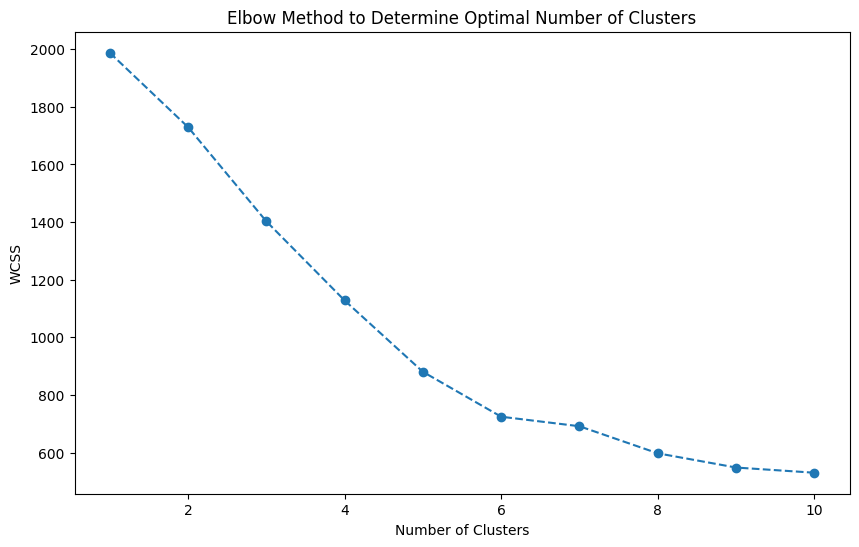

In [13]:

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Graph: Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.show()

In [24]:
kmeans = KMeans(n_clusters=6, random_state=42)
y_kmeans = kmeans.fit_predict(X)
merged['Cluster'] = y_kmeans

### PCA for 2D visualization

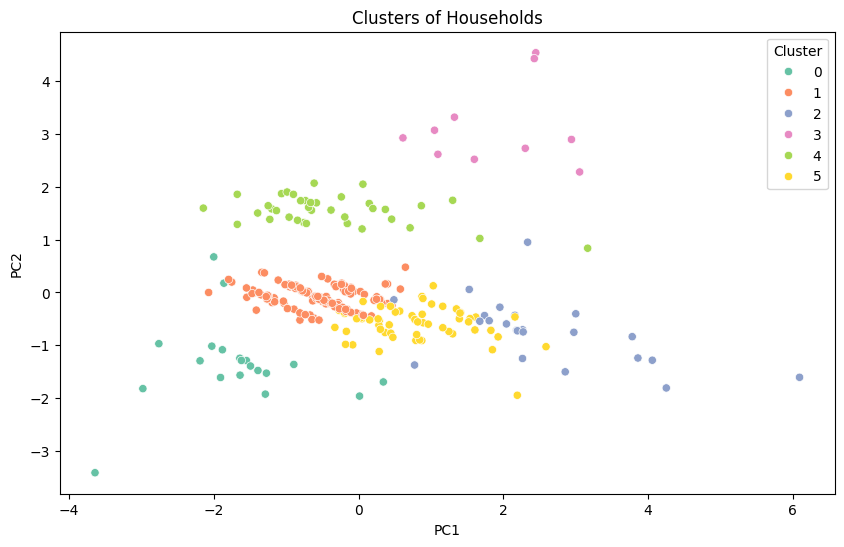

In [25]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = y_kmeans


plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='Set2')
plt.title('Clusters of Households')
plt.show()


### Cluster Analysis

In [41]:
'''
consumption_y - Monthly consumption
T_W1_E_11_1 - Usage of solar panels
W1_G_2_O1 - Energy source used for cooking
W1_H_4 - Household expenses for last month
W1_C_1 - No of household memebers
W1_B_8 - floor area of the house
T_W1_E_5_2  - Number of bedrooms

'''


cluster_summary = merged.groupby('Cluster')[numerical_features].mean().round(2)
cluster_summary

,T_W1_E_11_1,W1_G_2_O1,consumption_y,W1_H_4,W1_C_1,W1_B_8,T_W1_E_5_2
Cluster,,,,,,,
0,2.0,4.30,57.59,3.945000e+04,4.35,10586.40,1.75
1,2.0,1.02,65.04,5.902254e+04,3.24,761.31,2.02
2,1.0,1.08,161.39,2.590833e+05,4.04,6184.54,3.38
3,1.8,1.00,92.64,1.000000e+09,4.60,20976.60,3.20
4,2.0,1.11,84.64,6.421047e+04,4.08,99999.00,2.24
5,2.0,1.03,143.19,8.366102e+04,5.95,1130.61,2.80


In [40]:
cluster_summary = merged.groupby('Cluster')[numerical_features].size()
cluster_summary


Cluster
0     20
1    133
2     24
3     10
4     38
5     59
dtype: int64